In [1]:
import torch
import torch.nn as nn

In [2]:

class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias):
        super().__init__()
        self.d_out = d_out
        
        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer('mask',
                             torch.triu(torch.ones(context_length, context_length)))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim = -1)        

        context_vec = attn_weights @ values
        return context_vec


class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        self.heads = nn.ModuleList([CausalAttention(
            d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
            )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1)



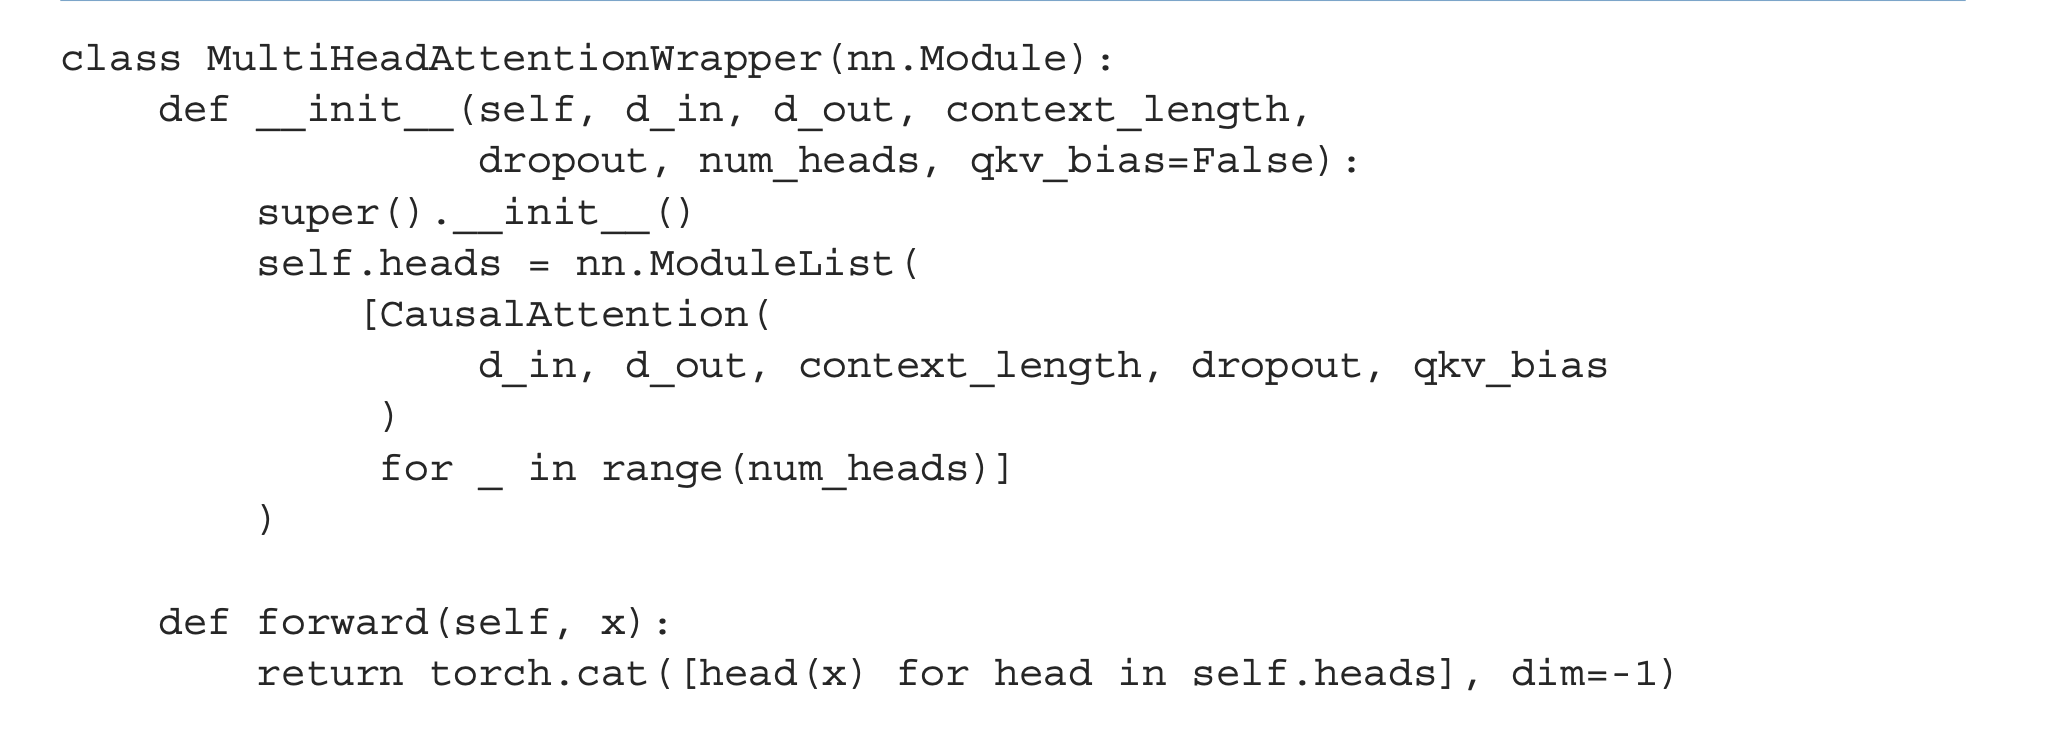

In [7]:
inputs = torch.tensor(
                [[0.43, 0.15, 0.89],
                [0.55, 0.87, 0.66],
                [0.57, 0.85, 0.64],
                [0.22, 0.58, 0.33],
                [0.77, 0.25, 0.10],
                [0.05, 0.80, 0.55]])

In [8]:
batch = torch.stack([inputs, inputs], dim = 0)

batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [14]:
torch.manual_seed(123)
d_in, d_out = 3, 2
context_length = batch.shape[1]

In [15]:
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads = 2)
context_vec = mha(batch)


In [17]:
context_vec

tensor([[[    nan,     nan,     nan,     nan],
         [-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0059,  0.5888,  0.3251],
         [-0.6286, -0.0609,  0.6158,  0.3774],
         [-0.5687, -0.0831,  0.5472,  0.3550],
         [-0.5519, -0.0996,  0.5328,  0.3484]],

        [[    nan,     nan,     nan,     nan],
         [-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0059,  0.5888,  0.3251],
         [-0.6286, -0.0609,  0.6158,  0.3774],
         [-0.5687, -0.0831,  0.5472,  0.3550],
         [-0.5519, -0.0996,  0.5328,  0.3484]]], grad_fn=<CatBackward0>)

In [18]:
context_vec.shape

torch.Size([2, 6, 4])

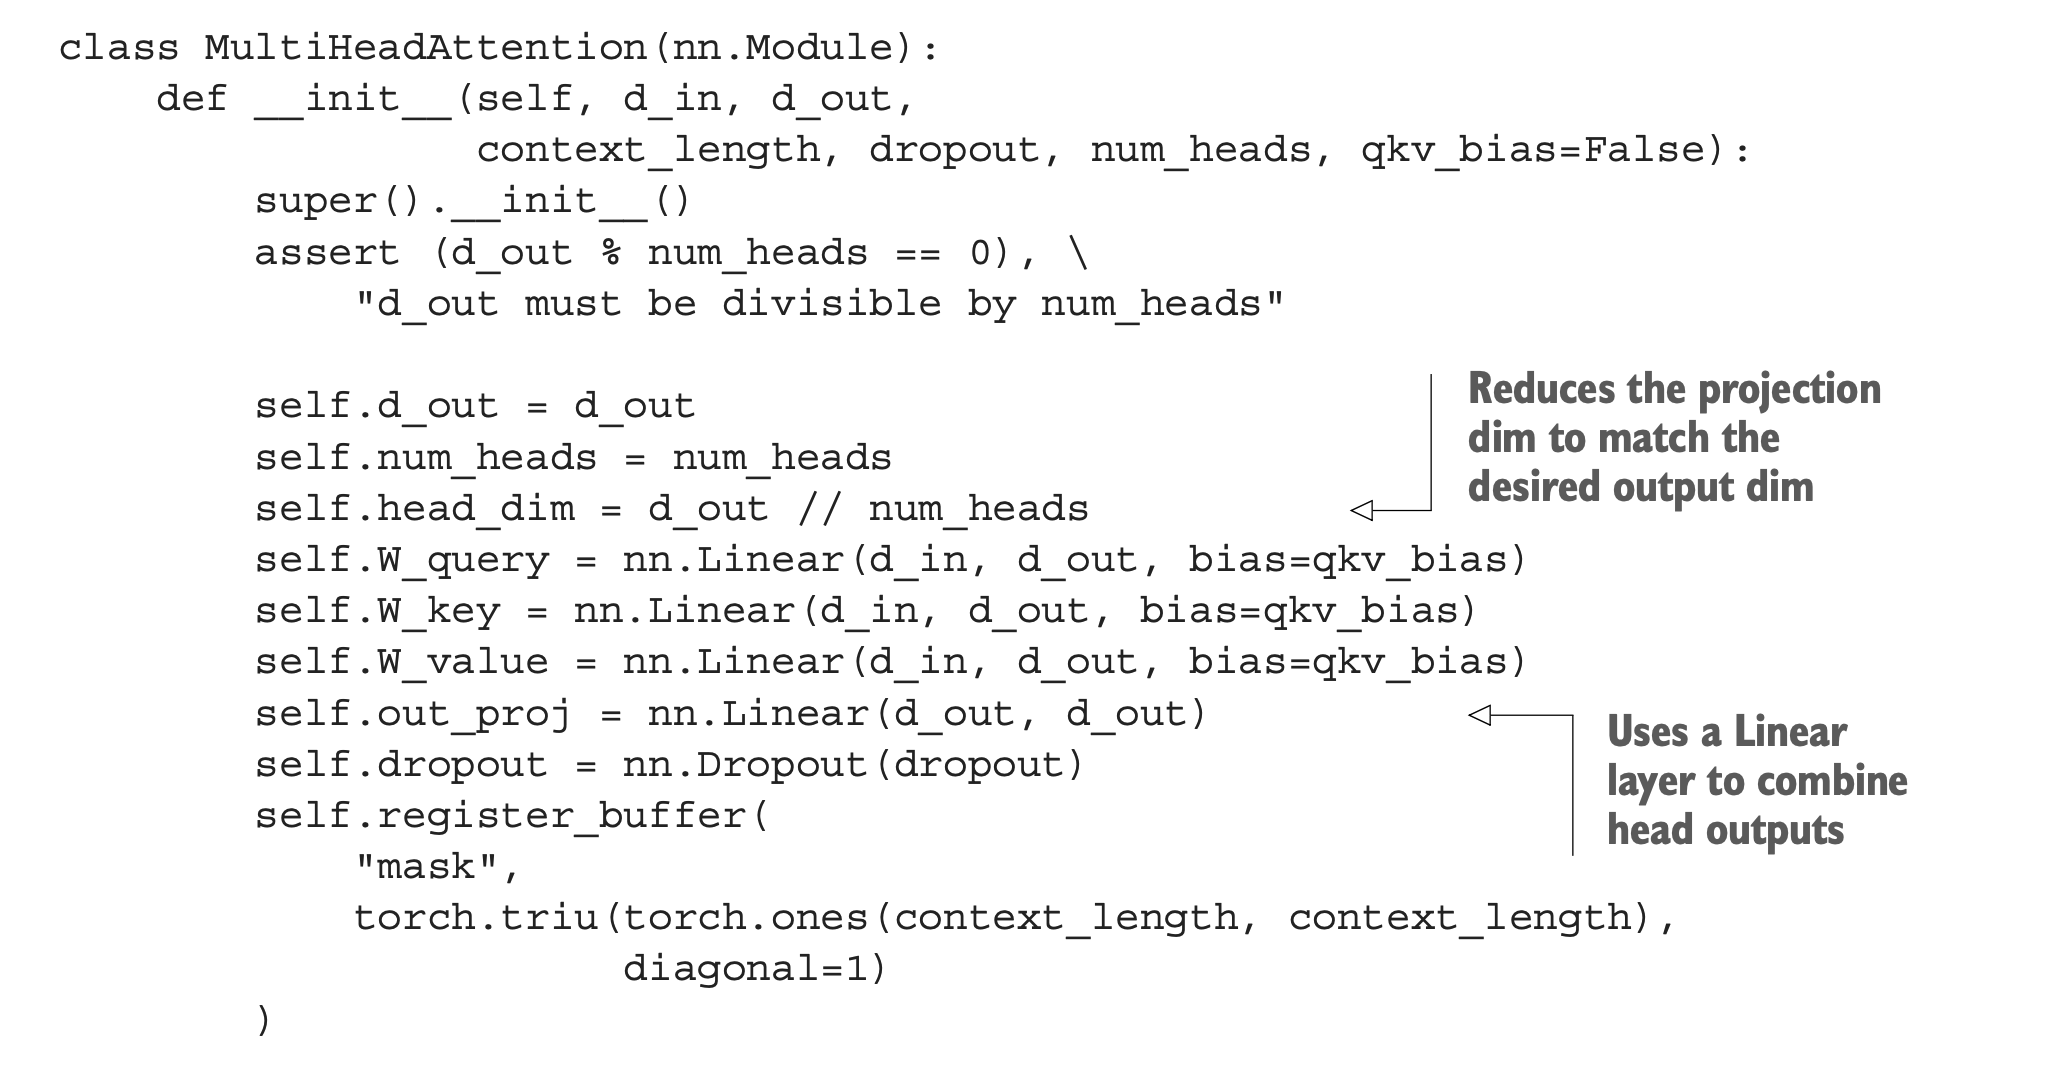

In [16]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()

        assert (d_out % num_heads == 0), "d_out should be divisible the number of heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out//num_heads
        self.dropout = nn.Dropout()

        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)

        self.register_buffer("mask", 
                             torch.triu(torch.ones(context_length, context_length), diagonal = 1)
                             )
        
    def forward(self, x):

        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)  ## shape() >> b, self.num_tokens, self.num_heads, self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec
    


## attn_scores >> b, self.num_heads, self.num_tokens, self.num_tokens
## attn_weights

## values >> b, self.num_heads, self.num_tokens, self.head_dim
## transpose() >> b, self.num_tokens, self.num_heads, self.head_dim


torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads = 2)
mha(batch)

tensor([[[0.3441, 0.2306],
         [0.3098, 0.3334],
         [0.2716, 0.4480],
         [0.3289, 0.2235],
         [0.1790, 0.5615],
         [0.2607, 0.4010]],

        [[0.2940, 0.7409],
         [0.3612, 0.3633],
         [0.2473, 0.4346],
         [0.2915, 0.3082],
         [0.2101, 0.4054],
         [0.2382, 0.4109]]], grad_fn=<ViewBackward0>)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

tensor([[[[ 2.0295e-01,        -inf,        -inf,        -inf,        -inf,
                  -inf],
          [ 3.0793e-01,  2.6311e-01,        -inf,        -inf,        -inf,
                  -inf],
          [ 3.0508e-01,  2.6067e-01,  2.6011e-01,        -inf,        -inf,
                  -inf],
          [ 1.6934e-01,  1.4469e-01,  1.4438e-01,  6.4815e-02,        -inf,
                  -inf],
          [ 1.6772e-01,  1.4330e-01,  1.4300e-01,  6.4194e-02,  9.7327e-02,
                  -inf],
          [ 2.0820e-01,  1.7789e-01,  1.7751e-01,  7.9688e-02,  1.2082e-01,
            9.0790e-02]],

         [[ 1.0813e-01,        -inf,        -inf,        -inf,        -inf,
                  -inf],
          [ 3.9973e-02, -2.9141e-03,        -inf,        -inf,        -inf,
                  -inf],
          [ 4.2025e-02, -3.0637e-03, -2.4565e-03,        -inf,        -inf,
                  -inf],
          [ 2.0194e-03, -1.4722e-04, -1.1804e-04, -4.9789e-04,        -inf,
             

tensor([[[0.3441, 0.2306],
         [0.3098, 0.3334],
         [0.2716, 0.4480],
         [0.3289, 0.2235],
         [0.1790, 0.5615],
         [0.2607, 0.4010]],

        [[0.2940, 0.7409],
         [0.3612, 0.3633],
         [0.2473, 0.4346],
         [0.2915, 0.3082],
         [0.2101, 0.4054],
         [0.2382, 0.4109]]], grad_fn=<ViewBackward0>)

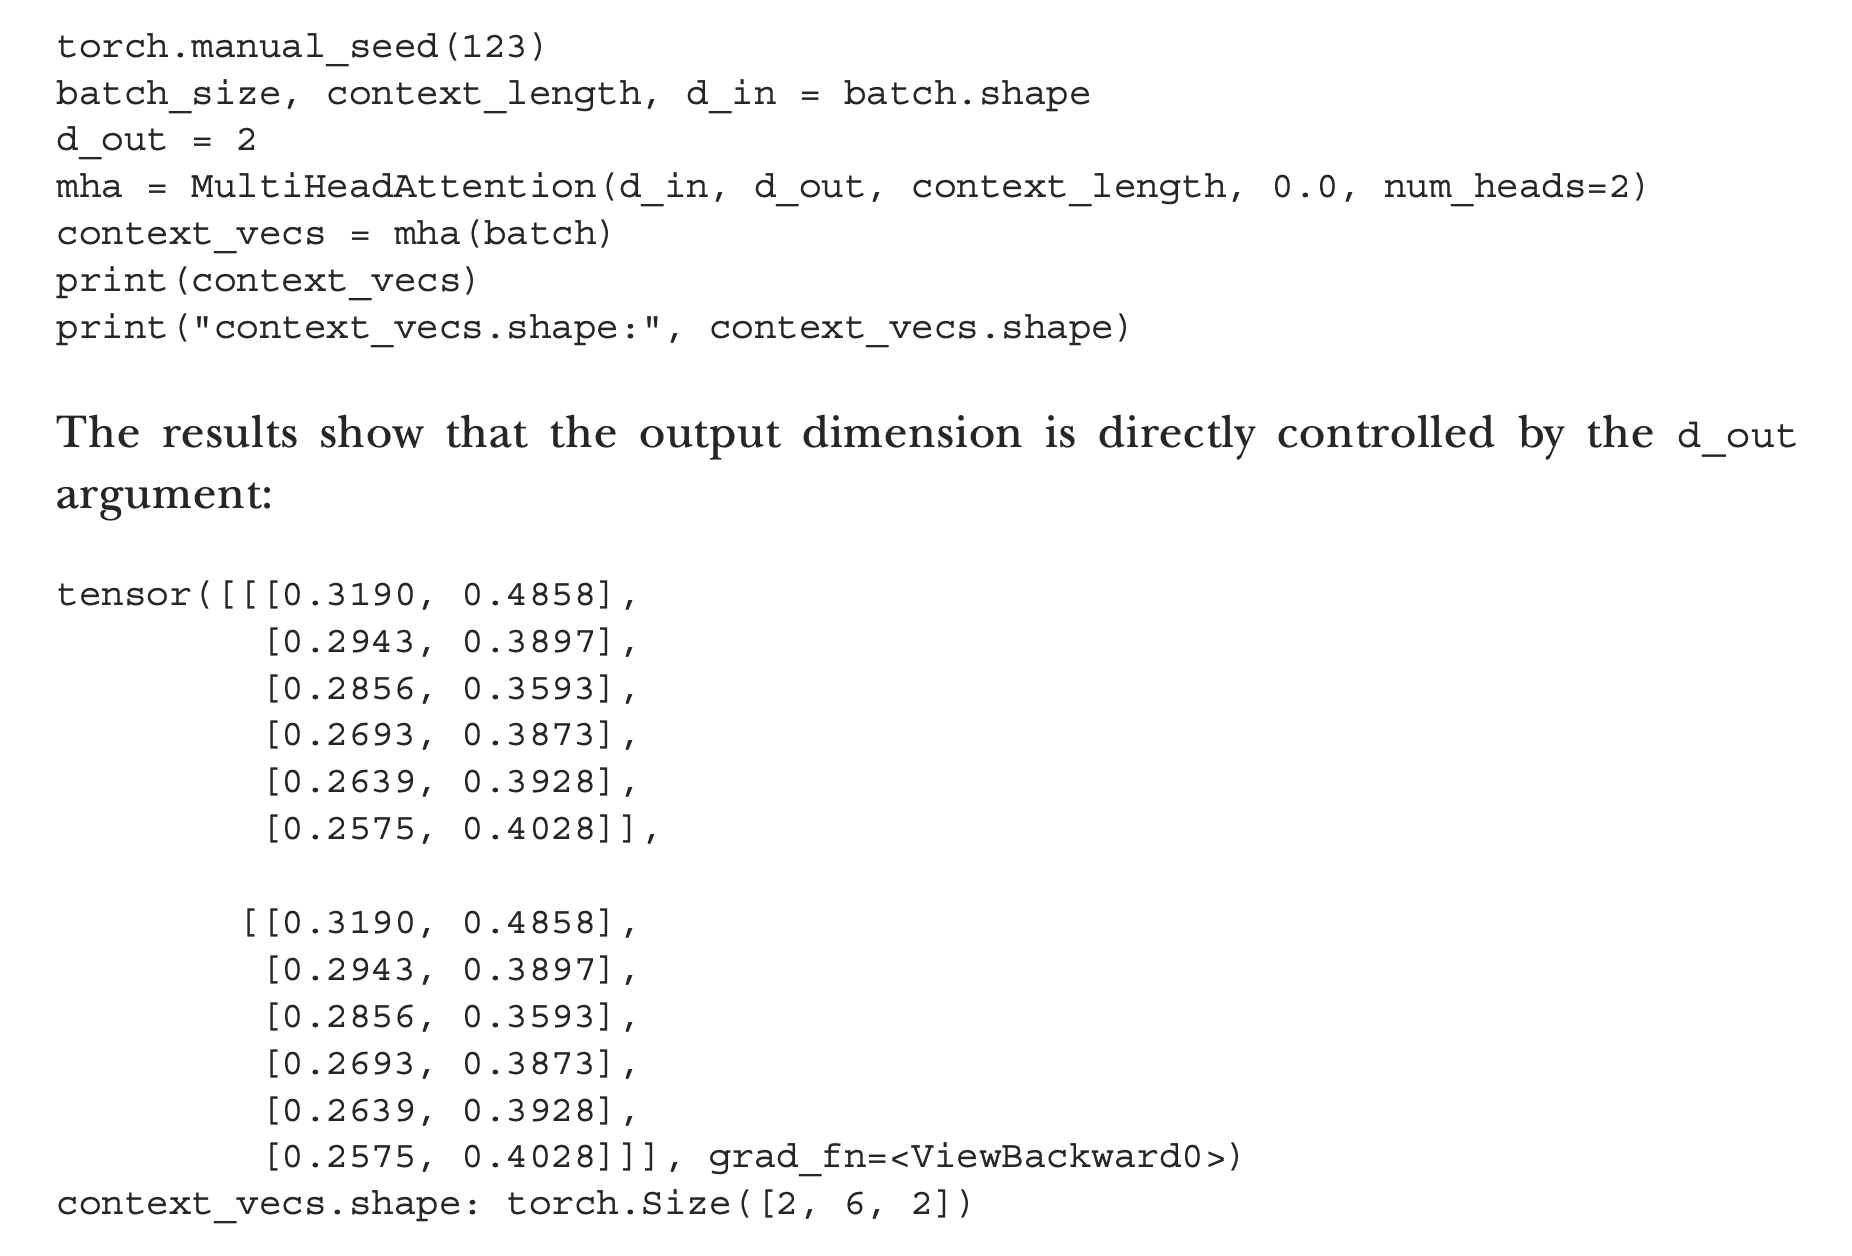

In [ ]:
## b, num_tokens, self.num_heads, self.head_dim

## b, self.num_heads, self.num_tokens, self.head_dim

torch.Size([3, 4, 2, 5])

In [43]:
a = torch.rand(1, 2, 3, 4)


In [46]:
print(a @ a.transpose(2, 3))
print((a @ a.transpose(2, 3)).shape)

tensor([[[[2.2895, 0.8371, 1.3928],
          [0.8371, 0.3740, 0.4494],
          [1.3928, 0.4494, 1.2581]],

         [[0.6378, 0.5905, 0.6382],
          [0.5905, 0.8000, 0.4848],
          [0.6382, 0.4848, 0.7008]]]])
torch.Size([1, 2, 3, 3])


In [48]:
a

tensor([[[[0.5300, 0.9356, 0.9819, 0.4110],
          [0.2879, 0.4350, 0.1694, 0.2705],
          [0.1740, 0.1762, 0.8907, 0.6352]],

         [[0.2929, 0.0072, 0.7181, 0.1904],
          [0.0051, 0.0117, 0.6601, 0.6034],
          [0.5058, 0.0201, 0.6626, 0.0740]]]])

In [50]:
first_head = a[0, 0, :, :]
second_head = a[0, 1, :, :]


In [51]:
first_res = first_head @ first_head.T
second_res = second_head @ second_head.T


In [53]:
print(first_res)
print(second_res)

tensor([[2.2895, 0.8371, 1.3928],
        [0.8371, 0.3740, 0.4494],
        [1.3928, 0.4494, 1.2581]])
tensor([[0.6378, 0.5905, 0.6382],
        [0.5905, 0.8000, 0.4848],
        [0.6382, 0.4848, 0.7008]])


In [56]:
a @ a.transpose(2, 3)

tensor([[[[2.2895, 0.8371, 1.3928],
          [0.8371, 0.3740, 0.4494],
          [1.3928, 0.4494, 1.2581]],

         [[0.6378, 0.5905, 0.6382],
          [0.5905, 0.8000, 0.4848],
          [0.6382, 0.4848, 0.7008]]]])

### Understanding the PyTorch contiguous

In [60]:
torch.manual_seed(5)

x = torch.randn(2, 3, 4)
y = x.transpose(1, 2)

In [62]:
print(y.is_contiguous())

False


In [63]:
print(x.is_contiguous())

True


In [65]:
x

tensor([[1, 2, 3],
        [4, 5, 6]])

In [64]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
x.stride()

(3, 1)

In [68]:
x[:, ::2]

tensor([[1, 3],
        [4, 6]])

In [69]:
x[:]

tensor([[1, 2, 3],
        [4, 5, 6]])

In [70]:
a = torch.tensor([range(1, 13)])
a

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

In [72]:
a = a.view(4, 3)

a

tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])

In [75]:
a.stride()

b = a[::2, ::2]
b

tensor([[1, 3],
        [7, 9]])

In [76]:
b.is_contiguous()

False

In [77]:
b.stride()

(6, 2)

In [ ]:
a = torch.tensor([range(1, 13)])
a = a.view(4, 3)
print(a.is_contiguous())
print(a.stride())
print()
b = a[::2, ::2]
print(b.is_contiguous())
print(b.stride())


In [78]:
import torch

# Step 1: Create a tensor with values 1 to 12
a = torch.tensor([range(1, 13)])  # Shape (1, 12)

# Step 2: Reshape to (4,3)
a = a.view(4, 3)  # Shape (4,3)
a_contiguous = a.is_contiguous()
a_stride = a.stride()

# Step 3: Apply slicing a[::2, ::2]
b = a[::2, ::2]  # Selects every second row and every second column
b_contiguous = b.is_contiguous()
b_stride = b.stride()

# Display results
a_results = {"Shape": a.shape, "Is Contiguous": a_contiguous, "Stride": a_stride}
b_results = {"Shape": b.shape, "Is Contiguous": b_contiguous, "Stride": b_stride}

a_results, b_results

({'Shape': torch.Size([4, 3]), 'Is Contiguous': True, 'Stride': (3, 1)},
 {'Shape': torch.Size([2, 2]), 'Is Contiguous': False, 'Stride': (6, 2)})